In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from utils import *
from pathlib import Path

# Parameters

In [0]:
DATA_PATH=Path('Data/experiment')
DATA_PATH.mkdir(exist_ok=True)

PATH = Path('Data/')
PATH.mkdir(exist_ok= True)

OUT_PATH = Path('Output/')
OUT_PATH.mkdir(exist_ok = True)



In [0]:
#Set up paramenters, change filename to test different datasets

args = {
    "data_dir": PATH,
    "full_data_dir": DATA_PATH,
    "output_dir": OUT_PATH,
    "train_file": 'train_3000_train.csv',
    "val_file": 'train_3000_val.csv',
    'test_file': 'test_onehot.csv',
    "model_name": 'model_3000.h5'
}

# Tokenization

In [0]:
train_data = pd.read_csv(args['full_data_dir']/args['train_file'])
val_data = pd.read_csv(args['full_data_dir']/args['val_file'])
test_data = pd.read_csv(args['data_dir']/args['test_file'])

In [171]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(2400, 6)
(600, 6)
(50000, 6)


In [0]:
#Concat train and validation test 

train_all = pd.concat([train_data, val_data])
train_all = train_all.sample(frac = 1)

In [173]:
train_all.shape

(3000, 6)

In [174]:
train_data.head()

,text,rating_1,rating_2,rating_3,rating_4,rating_5
0,\n Curious as to why this place hadn't closed ...,0,1,0,0,0
1,"\n Sure, you could go to one of the steakhouse...",0,0,0,0,1
2,\n i have never had such bad service in my lif...,1,0,0,0,0
3,\n Great food and great staff. Very friendly a...,0,0,0,0,1
4,\n Panda Express sounds good. I only gave them...,0,1,0,0,0


In [0]:
label_cols = list(train_data.columns[1:])

In [0]:
text_train = train_data.text.values
text_test = test_data.text.values
label_train = train_data[label_cols].values
label_test = test_data[label_cols].values

In [0]:
#Set up basic config parameters:
maxLen = 256
maxFeatures = 20000
embed_size = 50

In [0]:
#Text preprocessing using Keras:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = maxFeatures)
tokenizer.fit_on_texts(list(text_train))
tokenized_train = tokenizer.texts_to_sequences(text_train)
tokenized_test = tokenizer.texts_to_sequences(text_test)

In [0]:
#Pad sequence using Keras:
from keras.preprocessing.sequence import pad_sequences

X_trainset = pad_sequences(tokenized_train, maxlen = maxLen)
X_testset = pad_sequences(tokenized_test, maxlen = maxLen)

# Model

In [0]:
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding

In [0]:
# Load GloVe model:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('Data/glove.6B.50d.txt')

In [0]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  
    
    # define dimensionality of your GloVe word vectors
    emb_dim = word_to_vec_map["cucumber"].shape[0] 
    
    # Initialize the embedding matrix 
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer  
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)

    # Build the embedding layer
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [0]:
def MultiClassClf_base(input_shape, word_to_vec_map, word_to_index):
    
    sentence_indices = Input(shape = input_shape, dtype= 'int32')
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices)   
    
    X = Bidirectional(LSTM(50,return_sequences =True))(embeddings)
    X = Dropout(0.1)(X)
    X = GlobalMaxPooling1D()(X)
    X = Dense(50, activation = 'relu')(X)
    X = Dropout(0.1)(X)
    X = Dense(5)(X)
    X = Activation('softmax')(X)

    model = Model(inputs = sentence_indices, outputs = X)

    return model

In [0]:
def build_model():
    model = MultiClassClf_base((maxLen,), word_to_vec_map, word_to_index)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

# Training

In [185]:
# Perform kfold cross validation
k = 4
num_val_samples = len(X_trainset) // k
num_epochs = 25
all_loss_histories = []
all_accuracy_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    X_val = X_trainset[i * num_val_samples: (i + 1) * num_val_samples]
    y_val = label_train[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_X_train = np.concatenate(
        [X_trainset[:i * num_val_samples],
         X_trainset[(i + 1) * num_val_samples:]],
        axis=0)
    partial_y_train = np.concatenate(
        [label_train[:i * num_val_samples],
         label_train[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_X_train, partial_y_train,
                        validation_data=(X_val, y_val),
                        epochs=num_epochs, batch_size=32, verbose=0)
    loss_history = history.history['val_loss']
    all_loss_histories.append(loss_history)
    val_acc_history = history.history['val_acc']
    all_accuracy_histories.append(val_acc_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [0]:
average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_accuracy_histories]) for i in range(num_epochs)]

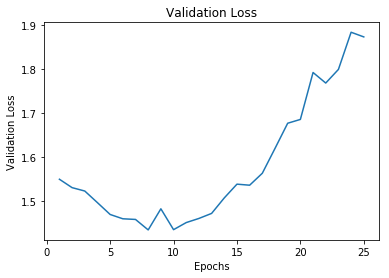

In [187]:
#Plot epoch vs loss
plt.plot(range(1, len(average_loss_history) + 1), average_loss_history)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss')
plt.show()

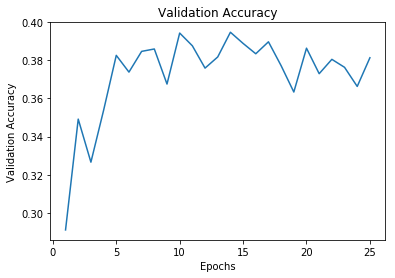

In [188]:
#Plot epoch vs accuracy
plt.plot(range(1, len(average_acc_history) + 1), average_acc_history)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy')
plt.show()

In [189]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(X_trainset, label_train,
          epochs=10, batch_size=32, verbose=0)


# Evaluation

In [190]:
loss, acc = model.evaluate(X_testset, label_test)
print()
print("Test accuracy = ", acc)
print ('Test loss = ', loss)

50000/50000 [==============================] - 492s 10ms/step

Test accuracy =  0.34446
Test loss =  1.4872553073120116


In [191]:
#Predict label
label_test_pred = model.predict([X_testset], batch_size=1024, verbose=1)

50000/50000 [==============================] - 20s 408us/step


In [192]:
#Compute metrics
from sklearn.metrics import fbeta_score

preds2 = np.argmax(label_test_pred, axis = 1)
y_true = np.argmax(label_test, axis = 1)

fbeta = fbeta_score(preds2, y_true, average='weighted', beta=1)

print('f1-macro = ',fbeta)

f1-macro =  0.39911570670633884


In [0]:
# Save test result:
result = {
    "Test loss": loss,
    "Accuracy ": acc,
    "f1 - macro": fbeta
}

output_eval_file = os.path.join(OUT_PATH, "test_results.txt")
if os.path.exists(output_eval_file):
    cmd = 'a'
else: cmd = 'w'
  
  
with open(output_eval_file, cmd) as writer:
    writer.write("****** Test Results******"+"\n")
    writer.write("Model "+ args['model_name']+"\n")
    for key in sorted(result.keys()):
        writer.write("%s = %s\n" % (key, str(result[key])))


In [0]:
#Save model
model.save(os.path.join(args['output_dir'],args['model_name']))